Лабораторная работа №8. Рекуррентные нейронные сети для анализа временных рядов

In [1]:
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pdb
# !python3 -m pip install tqdm
import pandas as pd
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import datetime
import matplotlib
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import time
from tqdm import tqdm
from sklearn.metrics import  mean_squared_error 
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Задание 1.
Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).


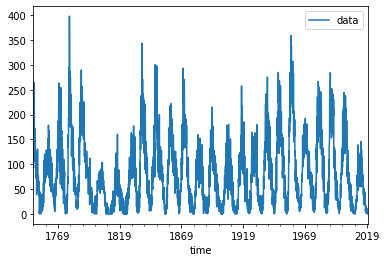

In [2]:
dataset_path = '../data/sunspots/Sunspots.csv'

time_series = []
with open(dataset_path, "r") as f:
    f.readline()
    for line in f:
        line = line.strip()
        i, date, mean = line.split(',')
        mean = float(mean)
        date = datetime.datetime.strptime(date, "%Y-%m-%d")
        time_series.append((date, mean))
        

df = pd.DataFrame(time_series, columns=['time','data']).set_index('time')
df.plot()
plt.show()


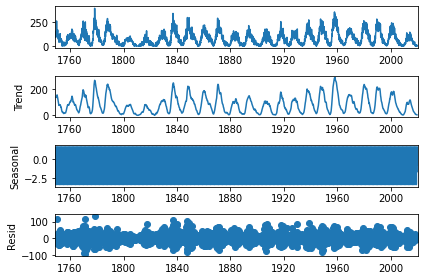

In [3]:
decomposition = seasonal_decompose(df)
decomposition.plot()
plt.show()

Задание 2.
Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.


In [4]:
series_len = len(df)
test_len = int(series_len * 0.1)
train_len = series_len - test_len
val_len = int(train_len * 0.1)
train = df.iloc[:-test_len, :]
test = df.iloc[-test_len:, :]
val = train.iloc[-val_len:, :]
train = train.iloc[:-val_len, :]

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

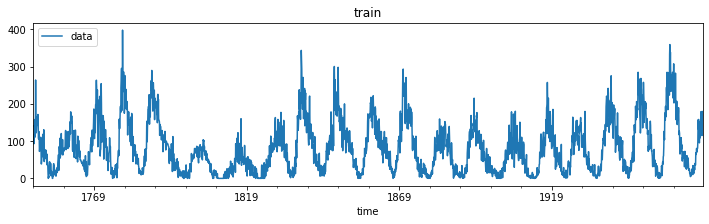

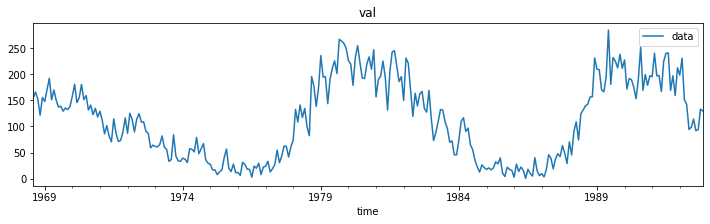

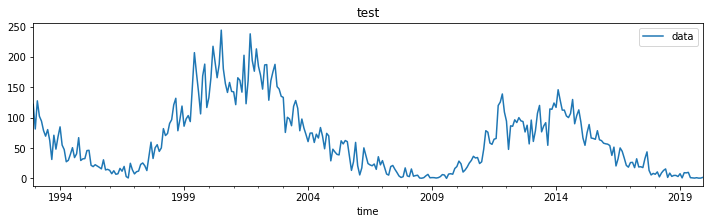

In [5]:
train.plot(figsize=(12,3), title='train')
val.plot(figsize=(12,3), title='val')
test.plot(figsize=(12,3), title='test')
plt.show()

Задание 3.
Примените модель ARIMA для прогнозирования значений данного временного ряда.


In [6]:
X = df.values
train_size = int(len(X) * 0.8)
train_values, test_values = X[0:train_size], X[train_size:len(X)]
history = [x for x in train_values]
arima_predictions = list()
for t in tqdm(range(len(test_values))):
    model = statsmodels.tsa.arima_model.ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    arima_predictions.append(output[0])
    history.append(test_values[t])

37%|███▋      | 244/651 [02:08<03:52,  1.75it/s]/home/ermolkin/study/mo/prev/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████| 651/651 [05:03<00:00,  2.15it/s]


Test MSE: 538.131


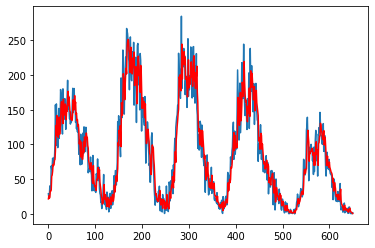

In [8]:
error = mean_squared_error(test_values, arima_predictions)
print('Test MSE: %.3f' % error)

plt.plot(test_values)
plt.plot(arima_predictions, color='red')
plt.show()

Задание 4.
Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).


In [9]:
def create_dataset(series, time_steps):
    X = []
    y = []
    for i in range(len(series) - time_steps):
        x = series[i:i + time_steps]
        x = np.array(x).reshape(time_steps, 1)
        prediction = series[i + time_steps]
        X.append(x)
        y.append(prediction)
    return np.array(X), np.array(y)

time_steps = 25
x_train, y_train = create_dataset(list(train.values), time_steps)
x_val, y_val = create_dataset(list(val.values), time_steps)
x_test, y_test = create_dataset(list(test.values), time_steps)

print(x_train.shape)
print("Train size: %d, test size: %d, val size: %d" % (len(x_train), len(x_test), len(x_val)))

(2610, 25, 1)
Train size: 2610, test size: 300, val size: 267


In [18]:
batch_size = 32
series_input = keras.Input(shape=(time_steps, 1, ))

cells = [
    keras.layers.LSTMCell(64),
    keras.layers.LSTMCell(64),
    keras.layers.LSTMCell(128),
]

model = keras.layers.RNN(cells)(series_input)
model = keras.layers.Dropout(0.3)(model)
model = keras.layers.Dense(128)(model)
model = keras.layers.Dense(64)(model)
prediction = keras.layers.Dense(1)(model)
model = keras.Model(series_input, prediction)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 25, 1)]           0         
_________________________________________________________________
rnn_1 (RNN)                  (None, 128)               148736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 173,569
Trainable params: 173,569
Non-trainable params: 0
_______________________________________________________

In [19]:
history = model.fit(
    x_train, y_train,
    epochs=4,
    batch_size=16,
    validation_data=(x_val, y_val),
    verbose=1
)

Train on 2610 samples, validate on 267 samples
Epoch 1/4
2610/2610 [==============================] - 19s 7ms/sample - loss: 34.3238 - val_loss: 21.5971
Epoch 2/4
2610/2610 [==============================] - 10s 4ms/sample - loss: 20.7242 - val_loss: 22.9620
Epoch 3/4
2610/2610 [==============================] - 10s 4ms/sample - loss: 20.3731 - val_loss: 21.8338
Epoch 4/4
2610/2610 [==============================] - 10s 4ms/sample - loss: 20.2013 - val_loss: 20.7690


300/300 [==============================] - 0s 623us/sample - loss: 14.7361


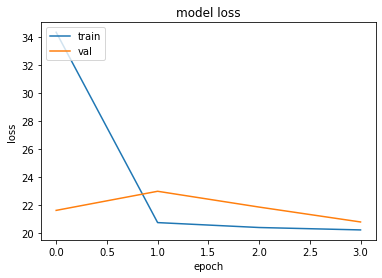

In [20]:
model.evaluate(x_test, y_test)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'val'], loc='upper left')
plt.show()

Test MSE: 464.095


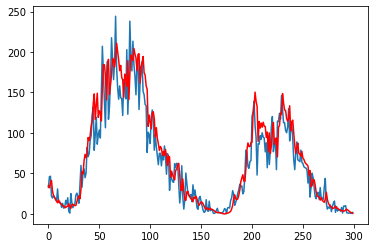

In [21]:
predictions = model.predict(x_test)
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % error)
plt.plot(y_test)
plt.plot(predictions, color='red')
plt.show()